In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as T

import time
import pydot
import pickle
import lasagne
import theano

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
def load_dataset(ds, num_files):
    datasets = []
    targets = []

    for i in range(num_files):
        print i
        datasets.append(np.load('../data/{}/imgs_{}.npy'.format(ds, str(i).zfill(4))).reshape(-1, 1, 512, 512))
        targets.append(np.load('../data/{}/masks_{}.npy'.format(ds, str(i).zfill(4))).reshape(-1, 1, 512, 512))

    dataset = np.vstack(datasets)
    targets = np.vstack(targets)

    track_targets = targets.copy()
    track_targets[track_targets <= 0] = 0
    
    return dataset, track_targets

In [4]:
dataset, track_targets = load_dataset('not_so_noisy', 1)

0


In [5]:
X_y = train_test_split(dataset, track_targets)

## load pretrained on big images network

In [6]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=5e-1,
                      c_sub_objs=[1e-2, 5e-1, 1, 1],
                      c_sub_obj_cs=[1e-2, 5e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

In [7]:
network.load('../weights/', '3cascades_not_clear_trained')

In [8]:
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

complexity, max_complexity, miltipliers, constants = network.compute_complexity()
result = complexity[0] * network.input_X.shape[0]

for i in range(len(complexity) - 1):
    result += complexity[i + 1] * miltipliers[i] + 10 * constants[i]
    
estimate_complexity = theano.function([network.input_X, network.targets], result / complexity[0] / network.input_X.shape[0])

def compute_recall_by_num_noise(dataset, targets, t):
    dataset_by_num_noise = {}

    for i in xrange(len(dataset)):
        num_noise = ((dataset[i] * (1 - targets[i])) == 5).sum()

        if num_noise not in dataset_by_num_noise:
            dataset_by_num_noise[num_noise] = []

        dataset_by_num_noise[num_noise].append(i)
        
    recall_by_num_noise = {}

    for k, v in dataset_by_num_noise.items():
        recall_by_num_noise[k] = []

        for index in v:
            small_t = get_target(targets[index].reshape(1, 1, 512, 512))
            prediction = network.predict(dataset[index].reshape(1, 1, 512, 512).astype(np.float32))
            activation = prediction > t
            recall_by_num_noise[k].append((activation.sum(), small_t.sum(), (activation * small_t).sum()))
            
    return recall_by_num_noise, dataset_by_num_noise


def draw_recall_by_num_noise(recall_by_num_noises, thrs):
    for j, recall_by_num_noise in enumerate(recall_by_num_noises):
        counts, bins = np.histogram(recall_by_num_noise.keys())
        extended_bins = np.hstack((np.array([-np.inf]), bins, np.array([np.inf])))
        
        xs = []
        predictions = []
        targets = []
        right_answers = []
        
        early_stop = False
        for i in range(len(extended_bins) - 1):
            if early_stop:
                break
                
            examples = []
            for k, v in recall_by_num_noise.items():
                if k > extended_bins[i] and k <= extended_bins[i + 1]:
                    examples += v
            
            if not examples:
                for k, v in recall_by_num_noise.items():
                    if k > extended_bins[i]:
                        examples += v
                
                early_stop = True
           
            xs.append(extended_bins[i + 1] / 512**2)
            examples = np.array(examples)
    
            predictions.append(examples[:, 0].mean())
            targets.append(examples[:, 1].mean())
            right_answers.append(examples[:, 2].mean())
            
            if early_stop:
                break
        
        plt.plot(xs, predictions, label= 'P')
        plt.plot(xs, targets, label= 'TP + TN')
        plt.plot(xs, right_answers, label='TP')
        plt.legend(loc='best')
        plt.title('Recall = ' + str(thrs[j]))
        plt.xlabel('noise per cent')
        plt.yscale('log')
        plt.show()
        
        
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]
        

def draw_precision_by_num_noise(recall_by_num_noises, thrs, max_percentile=0.1, num_bins=30):
    for j, recall_by_num_noise in enumerate(recall_by_num_noises):
        counts, bins = np.histogram(recall_by_num_noise.keys(), bins=num_bins)
        extended_bins = np.hstack((np.array([-np.inf]), bins, np.array([np.inf])))
        
        xs = []
        precisions = []
        
        early_stop = False
        for i in range(len(extended_bins) - 1):
            if early_stop:
                break
                
            examples = []
            for k, v in recall_by_num_noise.items():
                if k > extended_bins[i] and k <= extended_bins[i + 1]:
                    examples += v
            
            if not examples:
                for k, v in recall_by_num_noise.items():
                    if k > extended_bins[i]:
                        examples += v
                
                early_stop = True
           
            xs.append(extended_bins[i + 1] / 512**2)
            examples = np.array(examples)
    
            precisions.append(examples[:, 2].sum() / float(examples[:, 0].sum()))
        
            if extended_bins[i + 1] / 512**2 > max_percentile:
                early_stop = True
            
            if early_stop:
                break
        
        plt.plot(xs, precisions, label= 'precision ' + str(thrs[j]))
    plt.legend(loc='best')
    plt.xlabel('noise per cent')
    plt.show()

In [9]:
def draw_precision_recall(x_val, y_val):
    prediction = network.predict(x_val)
    target = get_target(y_val)

    precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
    average_precision = average_precision_score(target.ravel(), prediction.ravel())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc='best')
    plt.show()
    
    for r in [0.90, 0.95, 0.99, 0.999]:
        print 'Recall:', recall[np.max(np.where(recall >= r))]
        print 'Precision:', precision[np.max(np.where(recall >= r))]
        print

In [11]:
x_val = dataset[:2000]
y_val = track_targets[:2000]

In [12]:
estimate_complexity(x_val, y_val)

array(1.8290013732910155)

In [18]:
network.evaluate(x_val, y_val)

In [13]:
def baseline_precision_recall(x_val, y_val):
    prediction = get_target(x_val).ravel()
    target = get_target(y_val).ravel()

    precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
    average_precision = average_precision_score(target.ravel(), prediction.ravel())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc='best')
    plt.show()

In [ ]:
network.load('../weights', '3cascades_not_clear_trained')
draw_precision_recall(x_val, y_val)

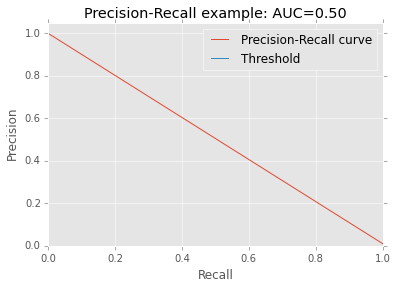

In [72]:
baseline_precision_recall(dataset[:2000], y_val[:2000])

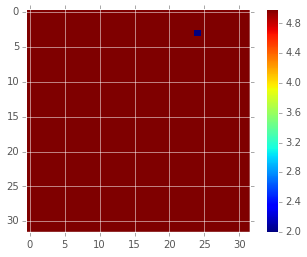

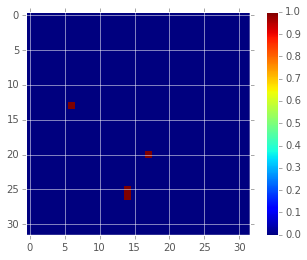

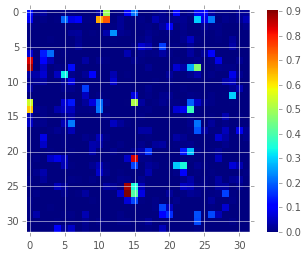

In [77]:
i = 1

plt.imshow(get_target(x_val)[i, 0], interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(get_target(y_val)[i, 0], interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(network.predict(x_val)[i, 0], interpolation='none')
plt.colorbar()
plt.show()

In [83]:
recall_by_num_noise99, dataset_by_num_noise99 = compute_recall_by_num_noise(dataset, targets, thr[np.max(np.where(recall >= 0.99))])
recall_by_num_noise95, dataset_by_num_noise95 = compute_recall_by_num_noise(dataset, targets, thr[np.max(np.where(recall >= 0.95))])
recall_by_num_noise90, dataset_by_num_noise90 = compute_recall_by_num_noise(dataset, targets, thr[np.max(np.where(recall >= 0.90))])

In [ ]:
with open('../weights/recall_by_num_noise.pkl', 'wb') as f:
    pickle.dump([recall_by_num_noise99,
                 recall_by_num_noise95,
                 recall_by_num_noise90], f)

In [ ]:
with open('../weights/dataset_by_num_noise.pkl', 'wb') as f:
    pickle.dump([dataset_by_num_noise99,
                 dataset_by_num_noise95,
                 dataset_by_num_noise90], f)

In [ ]:
with open('../weights/recall_by_num_noise.pkl') as f:
    recall_by_num_noise99, recall_by_num_noise95, recall_by_num_noise90 = pickle.load(f)

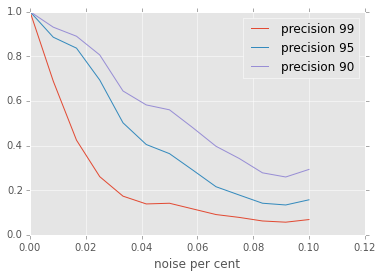

In [66]:
draw_precision_by_num_noise([recall_by_num_noise99,
                             recall_by_num_noise95,
                             recall_by_num_noise90], [99, 95, 90])

In [ ]:
def draw_fake_rate_by_num_noise(recall_by_num_noises, thrs, max_percentile=0.1, num_bins=30):
    fake_rates = []
    
    for j, recall_by_num_noise in enumerate(recall_by_num_noises):
        counts, bins = np.histogram(recall_by_num_noise.keys(), bins=num_bins)
        extended_bins = np.hstack((np.array([-np.inf]), bins, np.array([np.inf])))
        
        xs = []
        fake_rate = []
        
        early_stop = False
        for i in range(len(extended_bins) - 1):
            if early_stop:
                break
                
            examples = []
            for k, v in recall_by_num_noise.items():
                if k > extended_bins[i] and k <= extended_bins[i + 1]:
                    examples += v
            
            if not examples:
                for k, v in recall_by_num_noise.items():
                    if k > extended_bins[i]:
                        examples += v
                
                early_stop = True
           
            xs.append(extended_bins[i + 1] / 512**2)
            examples = np.array(examples)
    
            fake_rate.append(np.max((examples[:, 0].sum() - examples[:, 1].sum(), 0)) / float(examples[:, 0].sum()))
        
            if extended_bins[i + 1] / 512**2 > max_percentile:
                early_stop = True
            
            if early_stop:
                break
        
        plt.plot(xs, fake_rate, label= 'fake rate, recall = {}'.format(thrs[j]))
        fake_rates.append(fake_rate)
    plt.legend(loc='best')
    plt.xlabel('noise per cent')
    plt.show()
    
    return xs, fake_rates

In [ ]:
xs, fake_rates = draw_fake_rate_by_num_noise([recall_by_num_noise99,
                                              recall_by_num_noise95,
                                              recall_by_num_noise90], [99, 95, 90], num_bins=50)

In [ ]:
with open('../weights/fake_rates_by_num_noise.pkl', 'wb') as f:
    pickle.dump([xs, fake_rates], f)

(array([ 404.,  309.,  283.,  203.,  196.,  134.,  116.,  104.,   89.,  123.]),
 array([  3.81469727e-06,   5.00335693e-03,   1.00028992e-02,
          1.50024414e-02,   2.00019836e-02,   2.50015259e-02,
          3.00010681e-02,   3.50006104e-02,   4.00001526e-02,
          4.49996948e-02,   4.99992371e-02]),
 <a list of 10 Patch objects>)

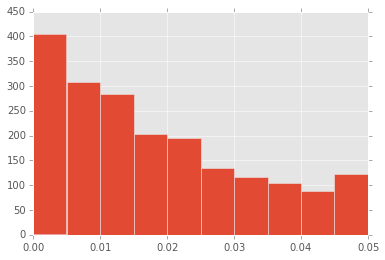

In [86]:
plt.hist(np.array(recall_by_num_noise99.keys()) / 512.0**2, bins=10)

In [81]:
dataset.shape

(2500, 1, 512, 512)

(array([ 468.,  360.,  317.,  219.,  209.,  150.,  119.,  106.,   92.,  460.]),
 array([  3.81469727e-06,   5.00335693e-03,   1.00028992e-02,
          1.50024414e-02,   2.00019836e-02,   2.50015259e-02,
          3.00010681e-02,   3.50006104e-02,   4.00001526e-02,
          4.49996948e-02,   4.99992371e-02]),
 <a list of 10 Patch objects>)

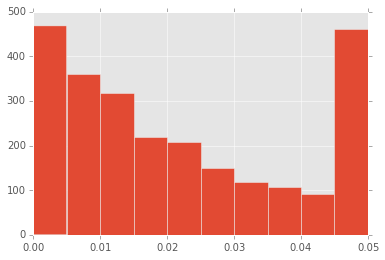

In [100]:
plt.hist(((dataset * (1 - targets)) == 5).reshape((-1, 512 * 512)).sum(axis=1) / 512.0**2)

In [91]:
(dataset==5).sum(axis=0).shape

(1, 512, 512)